In [1]:
import tensorflow as tf
import numpy as np
import keras.layers as kl
import keras.losses as loss
from keras import Sequential
import keras.optimizers as ko
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization
from keras.models import Model

2023-06-17 02:06:24.464953: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-17 02:06:24.493643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    dice_coef = numerator / (denominator + tf.keras.backend.epsilon())
    return 1 - dice_coef

In [3]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Calculate the binary cross-entropy
    cross_entropy = tf.keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)

    # Calculate the focal weights
    pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    focal_weights = alpha_factor * tf.pow(1 - pt, gamma)

    # Apply the focal weights to the cross-entropy loss
    focal_loss = focal_weights * cross_entropy

    # Compute the mean loss across all samples
    return tf.reduce_mean(focal_loss)

In [4]:
X = tf.reshape(tf.constant(np.linspace(0,1,100_000*16*16)), (100_000,16,16,1))
Y = tf.reshape(tf.constant(np.linspace(0,1,1000)), (1000,1))

2023-06-17 02:06:26.212295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-17 02:06:26.219681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-17 02:06:26.219860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:

# Define the encoder model
input_shape = X.shape[1:]
inputs = Input(shape=input_shape)

# Encoder
x = Conv2D(64, (2, 2), activation='relu', padding='same')(inputs)
skip = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(skip)  # Save this layer for skip connection
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
skip2 = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)  # Save this layer for skip connection

# Decoder
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = Add()( [x, skip2] )  # Skip connection
x = UpSampling2D((2, 2))(x)
x = Add()([x, skip])  # Skip connection

outputs = Conv2D(1, (3, 3), activation='elu', padding='same')(x)  # Final decoding layer

# Autoencoder
autoencoder_model = Model(inputs=inputs, outputs=outputs)

# Print the summary of the model
autoencoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   16448       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                              

In [6]:
autoencoder_model.compile(optimizer=ko.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['mse'])

In [7]:
hist = autoencoder_model.fit(X, X, epochs=5, batch_size=100)

Epoch 1/5


2023-06-17 02:06:28.398678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1000/1000 [==============================] - 7s 5ms/step - loss: 0.5262 - mse: 0.0084
Epoch 2/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5014 - mse: 4.2246e-04
Epoch 3/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5006 - mse: 1.4625e-04
Epoch 4/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5030 - mse: 9.2229e-04
Epoch 5/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5007 - mse: 1.6558e-04


In [8]:
dfm = pd.DataFrame(hist.history)

<Axes: >

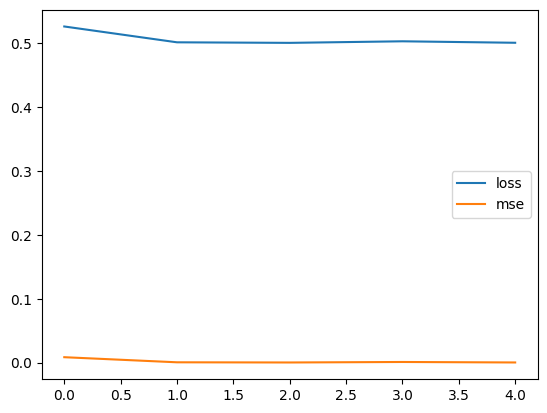

In [9]:
dfm.plot()

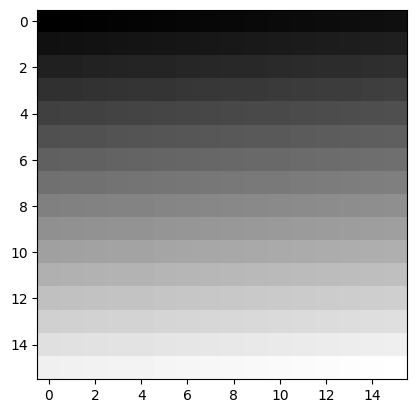

In [10]:
plt.imshow(X[0], cmap='gray')

In [11]:
pred = autoencoder_model.predict(X[0:1])

1/1 [==============================] - 0s 105ms/step


In [12]:
np.quantile(pred, .9)

0.006378169637173414

In [13]:
npred = (np.reshape(pred[0], (16,16)) * 255).astype(np.uint8)

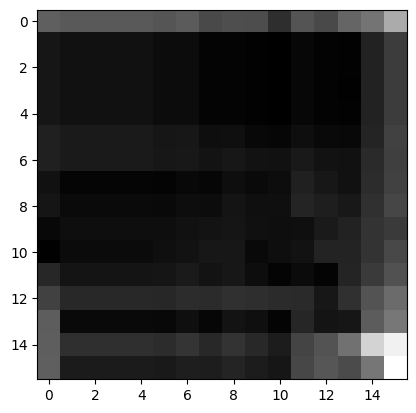

In [14]:
plt.imshow(pred[0], cmap='gray')